# Statistiques et images

Atelier à destination des professeurs de lycée, proposé dans le cadre des journées NSI de Lorraine en 2022.

## Chargement des modules et configuration
Ce notebook est écrit en Python3 et requiert les modules: ipywidgets, ipympl et scikit-image (et consorts).

Nous les chargeons ici, et une fonction <tt>lireImage</tt> est fournie pour lire facilement une image dans n'importe quel format et la transformer en niveaux de gris.

**Important:** les pixels des images sont exprimés entre 0 (noir) et 1 (blanc)

In [1]:
# chargement des modules requis
%matplotlib widget
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpi
from ipywidgets import interact, interactive, fixed, interact_manual
import colorsys

import skimage.color as skc
import ipywidgets as ipw

# un générateur de nombres aléatoires
rng=np.random.default_rng()

# affichage des images en niveaux de gris
mpl.rc('image', cmap='gray')

# fonction de chargement d'une image et transformation en niveaux de gris
def lireImage(fname):
    ima=mpi.imread(fname) # lecture du fichier image
    if len(ima.shape)==3: # dans le cas d'une image couleur
        ima=colorsys.rgb_to_yiq(*tuple(np.transpose(ima,(2,0,1))))[0] # transformation en niveaux de gris (composante y dans la représentation yiq)
    ima = ima/255 # expression des valeurs entre 0 et 1
    return ima

## Premier exercice: Une image est un ordre improbable
Cette cellule permet de montrer que les pixels d'une image, dès lors qu'on abandonne la structure spatiale, constituent un ensemble très convaincant de données aléatoires de grande taille. 

Une image est chargée et une petite application permet de mélanger de manière aléatoire les pixels afin de s'en rendre compte.

En exercice, il est demandé d'ajouter un bouton qui permet de présenter ces pixels dans un ordre particulier: rangés dans l'ordre croissant.

**Indice:** la fonction [<code>np.ndarray.sort()</code>](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.sort.html) sera utile pour faire un tri sur place, c'est-à-dire sans créer de nouveau tableau.

In [2]:
# lecture de l'image
ima=lireImage('accueil.jpg')

# fermeture de toutes les figures (remise à zéro des figures actives)
plt.close('all')

# préparation de la partie matplotlib de l'interface
output=ipw.Output()
# création de la figure, avec un seul sous graphique pour l'image
with output:
    fig1, iax = plt.subplots(1,1,constrained_layout=True)

# configuration du graphique image
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

# on conserve une copie de l'image : elle sera mélangée
sima=ima.copy()

# fonction de mise à jour de l'image affichée avec la nouvelle image im
def update_image(im):
    idisp.set_data(im)
    
    
# bouton de réinitialisation de l'image à la version originale
buttonR = ipw.Button(description='Reset',tooltip="Réinitialisation de l'image")
buttonR.on_click(lambda x: update_image(ima)) # lié à une fonction qui affiche l'image originale

# bouton de mélange des pixels
# fonction pour mélanger les pixels et mettre à jour l'affichage
def shuffle_image(b):
    rng.shuffle(sima.ravel())
    update_image(sima)

# création du bouton
buttonS = ipw.Button(description='Mélange',tooltip='Mélange les pixels')
buttonS.on_click(shuffle_image) # lié à la fonction de mélange

## EXERCICE : ajouter un bouton d'affichage des valeurs ordonnées (triées) de l'image
# fonction de tri (rangement) des pixels d'une image
def sort_image(b):
    np.ndarray.sort(sima.ravel())
    update_image(sima)
buttonT = ipw.Button(description='Ranger', tooltip='Ranger les pixels par ordre croissant')
buttonT.on_click(sort_image) # lié à la fonction de tri
## FIN EXERCICE

# organisation des widgets
controls=ipw.HBox([buttonR, buttonS, buttonT])
ipw.VBox([controls, output])

## Deuxième exercice: la représentation sous forme d'histogramme
On reprend le code précédent, mais on ajoute à l'application une visualisation de l'histogramme de l'image. Cela se fait en ajoutant une sous-figure, qui s'appelle "axe" en langage <tt>matplotlib</tt>.

Ce calcul et affichage d'histogramme est fait dans la partie "NOUVEAU CODE" ci-dessous. On utilise la fonction <code>np.histogram()</code> qui renvoie le tableau des fréquences (<code>freq</code>), mais également les limites des classes calculées (<code>edges</code>). En effet, on fournit un nombre de classes (<code>nbins=256</code>) et la plage de valeurs est automatiquement découpées en classes de même étendue. À noter que le tableau <code>edges</code> a un élément de plus que le tableau <code>freq</code>. Par ailleurs, la somme des fréquences est normalisée à 1.

En exercice, il est demandé d'afficher, superposées à l'histogramme, la moyenne sous forme d'une ligne vertical et l'écart-type sous forme d'une ligne horizontale à mi-hauteur (entre moy-std et moy+std).

**Indice:** on pourra utiliser les fonctions [<code>np.mean()</code>](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) et [<code>np.std()</code>](https://numpy.org/doc/stable/reference/generated/numpy.std.html#numpy.std) pour calculer la moyenne et l'écart-type, et la fonction [<code>hax.plot()</code>](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html) pour afficher une ligne.

In [3]:
# reprise du code précédent
ima=lireImage('accueil.jpg')

plt.close('all')

output=ipw.Output()
with output:
    # on ajoute un deuxième graphique pour afficher l'histogramme -> hax
    fig1, (iax, hax) = plt.subplots(1,2,constrained_layout=True)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

sima=ima.copy()

# NOUVEAU CODE
# affichage de l'histogramme
# préparation du graphique
hax.set_title('Histogramme')
hax.yaxis.set_label_position("right")
hax.yaxis.tick_right()
hax.set_xlim([0,1]) # évite de ne se concentrer que sur la plage de probas non nulles
# calcul de l'histogramme
nbbins=256
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=(0,1))
freq = freq/np.prod(ima.shape) # on normalise pour que la somme fasse 1 -> probabilité d'occurrence
# affichage de l'histogramme : hb=objet graphique qui sera mis à jour
hb=hax.bar(edges[:-1], freq, width=np.diff(edges),align="edge")

## EXERCICE: affichage de la moyenne et de l'écart-type
imoy=np.mean(ima.ravel()) # moyenne de l'image
ietype=np.std(ima.ravel()) # écart-type de l'image
max_freq=np.max(freq) # valeur maximale sur l'axe vertical de l'histogramme
lmoy,=hax.plot([imoy, imoy],[0,max_freq],'k-') # line verticale pour la moyenne (k=couleur noire)
letype,=hax.plot([imoy-ietype,imoy+ietype],[max_freq/2, max_freq/2],'k-',linewidth=5) # ligne horizontale épaisse pour l'écart-type
## FIN EXERCICE

# liste de couleurs pour afficher une couleur différente à chaque fois que l'histogramme est mis à jour
colors=['red','green','blue','orange']
icol=0
# mise à jour de l'histogramme
def update_hist():
    global icol
    # calcul de l'histogramme
    im=idisp.get_array()
    freq,edges=np.histogram(im.ravel(),bins=nbbins,range=(0,1))
    freq = freq/np.prod(im.shape)
    # on change la couleur
    col=colors[icol%len(colors)]
    icol=icol+1
    # mise à jour de l'objet graphique
    for r,f,s,e in zip(hb.patches,freq,edges[:-1],edges[1:]):
        r.set(height=f,x=s,width=e-s,edgecolor=col)
        
# FIN NOUVEAU CODE

def update_image(im):
    idisp.set_data(im)
    update_hist() # NOUVEAU CODE: ajout de la mise à jour de l'histogramme chaque fois que l'image change
    
buttonR = ipw.Button(description='Reset',tooltip="Réinitialisation de l'image")
buttonR.on_click(lambda x: update_image(ima)) 

def shuffle_image(b):
    rng.shuffle(sima.ravel())
    update_image(sima)

buttonS = ipw.Button(description='Mélange',tooltip='Mélange les pixels')
buttonS.on_click(shuffle_image) 

controls=ipw.HBox([buttonR, buttonS])
ipw.VBox([controls, output])

## Troisième exercice: effets d'une transformation affine
On voir pouvoir observer ici l'effet d'une transformation affine quand elle est appliquée à chaque échantillon d'un ensemble. On s'intéressera à la moyenne, l'écart-type ainsi que l'histogramme et on pourra en avoir une interprétation visuelle en terme d'amélioration d'image.

On reprend le code précédent et on ajoute une nouvelle sous-figure (axe) qui sera placée à gauche de l'image. Cette figure fournit le graphe de la fonction affine. Comme les pixels sont compris entre 0 et 1, on restreint l'affichage de ce graphe à l'intervalle [0,1] à la fois en abscisse et ordonnée. 

Deux réglettes (*sliders* en anglais) sont disponibles pour ajuster la fonction affine en modifiant l'ordonnée à l'origine ainsi que la pente. À chaque modification, l'effet sur l'image est affiché et l'histogramme de la nouvelle image, ainsi que sa moyenne et écart-type, sont recalculés. Notez que même si les valeurs des pixels peuvent sortir de l'intervalle [0,1] après transformation, toute valeur négative est affichée comme 0 (noir) et toute valeur supérieure à 1 est affichée comme 1 (blanc) (effets de saturation basse et haute respectivement).

En exercice, il est demandé d'étendre la plage de visualisation de l'histogramme afin de mieux visualiser l'effet de la transformation affine sur l'histogramme. Par ailleurs, on s'aperçoit que modifier la pente changer à la fois l'écart-type et la moyenne, alors que l'ordonnée à l'origine n'a d'impact que sur la moyenne. Il est demandé de modifier l'expression (paramétrage) de la fonction affine afin que la pente n'ait d'impact que sur l'écart-type.

**Indice:** on pourra travailler sur la variable <code>hrange=(min,max)</code> qui est aussi utilisée comme paramètre de la fonction <code>np.histogram</code>

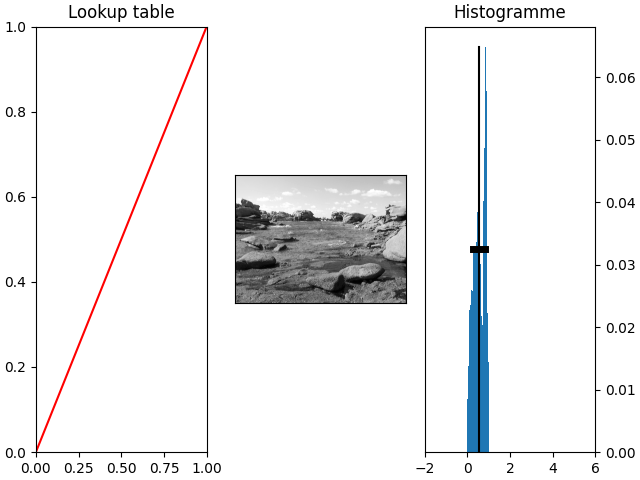

In [2]:
# reprise du code précédent
ima=lireImage('accueil.jpg')

plt.close('all')

output=ipw.Output()
with output:
    # NOUVEAU CODE: on ajoute un troisième graphique pour afficher la lookup table -> lax (sera mis en premier à gauche)
    fig1, (lax, iax, hax) = plt.subplots(1,3,constrained_layout=True)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

sima=ima.copy()

hax.set_title('Histogramme')
hax.yaxis.set_label_position("right")
hax.yaxis.tick_right()
#### RETIRE hrange=(0,1)
## EXERCICE (1): changer l'axe des abscisses pour qu'il soit plus large
## dec va de -1 à 1, mul va de -1 à 5, donc pour v allant de 0 à 1, mul*v+dec peut aller de -2 à 6 
hrange=(-2,6)
## FIN EXERCICE (1)
hax.set_xlim(hrange)

nbbins=256
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=hrange)
freq = freq/np.prod(ima.shape)
hb=hax.bar(edges[:-1], freq, width=np.diff(edges),align="edge")

imoy=np.mean(ima.ravel()) # moyenne de l'image originale
ietype=np.std(ima.ravel())
max_freq=np.max(freq)
lmoy,=hax.plot([imoy, imoy],[0,max_freq],'k-') 
letype,=hax.plot([imoy-ietype,imoy+ietype],[max_freq/2, max_freq/2],'k-',linewidth=5)

colors=['red','green','blue','orange']
icol=0
def update_hist():
    global icol
    im=idisp.get_array()
    freq,edges=np.histogram(im.ravel(),bins=nbbins,range=hrange)
    freq = freq/np.prod(im.shape)
    col=colors[icol%len(colors)]
    icol=icol+1
    for r,f,s,e in zip(hb.patches,freq,edges[:-1],edges[1:]):
        r.set(height=f,x=s,width=e-s,edgecolor=col)
        
# NOUVEAU CODE: mise à jour des infos de moyenne/écart-type
    max_freq=np.max(freq) # valeur maximale sur l'axe vertical de l'histogramme
    moy=np.mean(im.ravel()) # moyenne de l'image
    etype=np.std(im.ravel()) # écart-type de l'image
    lmoy.set_xdata([moy, moy])
    lmoy.set_ydata([0,max_freq])
    letype.set_xdata([moy-etype,moy+etype])
    letype.set_ydata([max_freq/2, max_freq/2])
# FIN NOUVEAU CODE

def update_image(im):
    idisp.set_data(im)
    update_hist() 

# NOUVEAU CODE: Lookup table -> jusqu'à la fin
v=np.linspace(0,1,256) # 256 valeurs entre 0 et 1 inclus
dec,mul=0,1 # initialisation des paramètres de la fonction affine (variables globales)

# fonction affine appliquée aux valeurs des pixels
def lut_fn(x,Dec,Mul):
#### RETIRE    return Mul*x+Dec

## EXERCICE (2): changer la fonction ci-dessus pour que Mul n'ait un impact que sur l'écart-type
    return Mul*(x-imoy)+Dec+imoy # imoy a été calculé à l'initialisation de l'histogramme
## FIN EXERCICE (2)

# sous-figure pour afficher la lookup table
lax.set_title('Lookup table')
lax.set_xlim(0,1) # on restreint l'affichage à un carré entre (x,y)=[0,0] et [1,1]
lax.set_ylim(0,1)
lp, =lax.plot(v,lut_fn(v,dec,mul),'r-') # création de l'objet graphique

# partie interactive
# application d'une nouvelle lookup table
def apply_lut(Dec,Mul):
    sima=lut_fn(ima,Dec,Mul) # génération de la nouvelle image
    y=lut_fn(v,Dec,Mul) # génération de la fonction affine
    update_image(sima) # mise à jour de l'image (+ histogramme)
    lp.set_ydata(y) # mise à jour de l'affichage de la LUT
    
# on retire les boutons et on ajoute les Sliders pour la valeur de dec et mul
# fonction appelée quand la valeur du slider change
def on_change_dec(change):
    global dec,mul
    dec=change['new'] # on met à jour à la variable globale dec
    apply_lut(dec,mul) # on appelle la fonction de mise à jour
# création du slider: les valeurs vont de -1 à 1 tous les 0.1 et la valeur initiale est dec
decSlider=ipw.FloatSlider(min=-1,max=1,step=0.1,value=dec, description="Ordonnée à l'origine")
# lien entre le slider et le callback
decSlider.observe(on_change_dec,names='value')

# idem pour mulSlider
def on_change_mul(change):
    global dec,mul
    mul=change['new']
    apply_lut(dec,mul)
mulSlider=ipw.FloatSlider(min=-1,max=5,step=0.1,value=mul,description='Pente')
mulSlider.observe(on_change_mul,names='value')

sliders=ipw.VBox([decSlider,mulSlider])
ipw.VBox([sliders, output])

## Quatrième exercice: Amélioration photométrique par normalisation
On passe à des cellules plus simples car sans interaction. Un affichage simple de l'image à côté de son histogramme est proposé.

Il est demandé de charger l'image <code>aqui.jpg</code> dont la visualisation est difficile. Quelle en est la valeur maximale ainsi que la valeur minimale ? Comment faire pour que les valeurs des pixels s'étendent sur tout l'intervalle [0,1] ? Quel effet sur la visualisation de l'image ?

**Indice:** on pourra utiliser les fonctions <code>a.max()</code> et <code>a.min()</code> pour obtenir les valeurs max et min sur un tableau <code>a</code>. Ce sont des alias vers les fonctions [<code>np.amax()</code>](https://numpy.org/doc/stable/reference/generated/numpy.amax.html#numpy.amax) et [<code>np.amin()</code>](https://numpy.org/doc/stable/reference/generated/numpy.amin.html#numpy.amin)

vmin=0.03529411764705882, vmax=0.1568627450980392


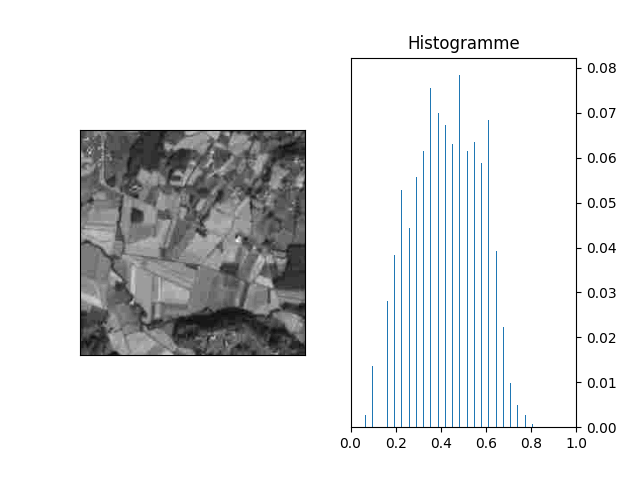

In [3]:
plt.close('all')
#### RETIRE ima=lireImage('accueil.jpg')

## EXERCICE
## charger l'image aqui.jpg: que voit-on ?
## quelle est la valeur min dans l'image ? quelle est la valeur max ?
## la normaliser de telle manière que min->0 et max->1
## qu'observe-t-on?
ima=lireImage('aqui.jpg') # image très sombre, très peu contrastée
vmin,vmax=ima.min(),ima.max()
print(f'vmin={vmin}, vmax={vmax}')
ima = (ima-vmin)/(vmax-vmin)
## FIN EXERCICE

# calcul de l'histogramme
nbbins=256
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=(0,1))
freq = freq/np.prod(ima.shape)

# affichage
fig1, (iax, hax) = plt.subplots(1,2)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

hax.set_title('Histogramme')
hax.yaxis.set_label_position("right")
hax.yaxis.tick_right()
hax.set_xlim([0,1])
hb=hax.bar(edges[:-1], freq, width=np.diff(edges),align="edge")

## Cinquième exercice: Egalisation d'histogramme
On présente ici une méthode plus évoluée pour faire de l'amélioration d'image.

On va également chercher à mieux occuper toute la plage de valeur [0,1] mais en cherchant un meilleur équilibre dans la distribution des valeurs. L'objectif est d'obtenir un histogramme plat.

Première question: Remplacer l'affichage de l'histogramme par celui de l'histogramme cumulé (fonction de répartition). On pourra tirer profit de la fonction [<code>np.cumsum()</code>](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) qui calcule la somme cumulée d'un tableau. Quelle forme doit avoir cet histogramme cumulé quand l'histogramme est plat ?

Deuxième question : remplacer chaque pixel de l'image par la valeur correspondante de la fonction de répartition; en notant $F(x)$ la fonction de répartition, remplacer chaque valeur de pixel $x$ par $F(x)$ dans l'image. Qu'observe-t-on ?

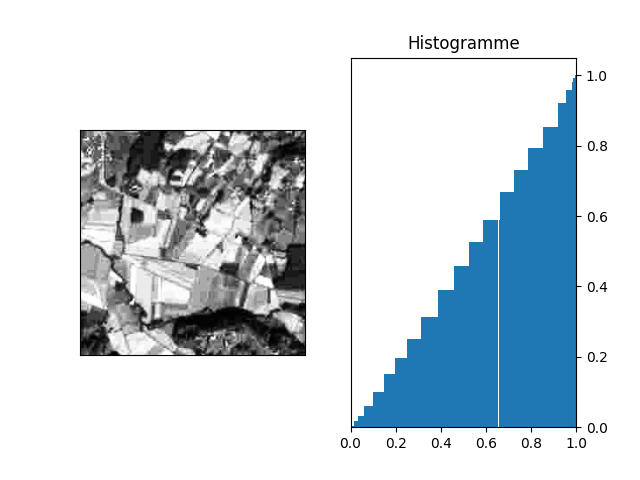

In [4]:
plt.close('all')
ima=lireImage('aqui.jpg')

nbbins=256
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=(0,1))
freq = freq/np.prod(ima.shape)
## EXERCICE (2)
## remplacer chaque valeur v dans l'image par la valeur F(v) ou F est l'histogramme cumulé. On utilisera une variable temporaire pour stocker
## la nouvelle image
## recalculer l'histogramme
F=np.cumsum(freq)
sima=ima.copy()
for s,f,v in zip(edges[:-1],edges[1:],F):
    sima[np.logical_and(ima>=s,ima<=f)]=v
ima=sima
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=(0,1))
freq = freq/np.prod(ima.shape)
## FIN EXERCICE (2)

fig1, (iax, hax) = plt.subplots(1,2)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

hax.set_title('Histogramme')
hax.yaxis.set_label_position("right")
hax.yaxis.tick_right()
hax.set_xlim([0,1])
#### RETIRE hb=hax.bar(edges[:-1], freq, width=np.diff(edges),align="edge")
## EXERCICE (1)
## afficher l'histogramme cumulé au lieu de l'histogramme (cf la fonction np.cumsum). Quelle forme devrait-il avoir avec un histogramme plat?
hb=hax.bar(edges[:-1], np.cumsum(freq), width=np.diff(edges),align="edge") # il devrait suivre la fonction identité
## FIN EXERCICE (1)

## Sixième exercice: Seuillage d'une image
On passe ici à la segmentation des images par binarisation: on veut séparer un ou des objets du fond.

Une manière simple de procéder est par seuillage : on choisit une valeur <tt>seuil</tt> et on met à 0 toutes les pixels sous ce seuil, et à 1 tous les pixels au-dessus. 

Un exemple est fourni ici avec un seuil à 0.7.

Question: en regardant l'histogramme, trouver une valeur de seuil plus appropriée.

In [7]:
plt.close('all')
ima=lireImage('motifs.jpg')

# calcul de l'histogramme
nbbins=256
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=(0,1))
freq = freq/np.prod(ima.shape)

## EXERCICE: 
## en analysant l'histogramme, trouver un seuil qui permet de bien séparer les motifs du fond
seuil=0.4 # (entre 0.25 et 0.45)
## faire le même exercice en chargeant d'autres images. Est-ce toujours si simple ? Quelle forme doit avoir l'histogramme pour que cela fonctionne ?
# REPONSE: il faut un histogramme bimodal
## FIN EXERCICE

## EXERCICE (OPTIONNEL)
## pour ceux qui sont le plus à l'aise, vous pouvez vous inspirer des cellules interactives ci-dessus pour ajouter un slider qui permet d'ajuster 
## interactivement le seuil
## FIN EXERCICE (OPTIONNEL)

#### RETIRE seuil=0.7
sima=ima.copy()
sima[ima<=seuil]=0
sima[ima>seuil]=1

# affichage: on ajoute un axe pour l'image seuillée
fig1, (iax, sax, hax) = plt.subplots(1,3)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

sax.get_xaxis().set_visible(False)
sax.get_yaxis().set_visible(False)
sdisp=sax.imshow(sima,vmin=0,vmax=1)

hax.set_title('Histogramme')
hax.yaxis.set_label_position("right")
hax.yaxis.tick_right()
hax.set_xlim([0,1])
hb=hax.bar(edges[:-1], freq, width=np.diff(edges),align="edge")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Septième exercice: la méthode de seuillage par k-means (avancé, ici 2-means)

Une méthode pour automatiser la détermination de ce seuil est celle des k-means : c'est une méthode de classification non supervisée qui présuppose un nombre de classes k. Ici, on va donc considérer que k vaut 2.

L'objectif est de trouver un seuil. La méthode des 2-means cherche à déterminer la moyenne optimale pour chaque classe. Ces moyennes sont appelées "centres" pour s'adapter au cas général où les valeurs à classifier sont vectorielles. Ici ces valeurs sont des scalaires et les centres sont simplement des nombres sur le segment [0,1]. Le seuil est automatiquement calculé comme le milieu des deux centres.

La méthode choisit deux centres de manière aléatoire, c'est-à-dire deux nombres entre 0 et 1. Le plus petit nombre est le centre de la classe 0 et le plus grand celui de la classe 1. Le seuil est calculé comme la moyenne de ces deux nombres, ce qui permet d'attribuer la classe 0 aux pixels sous ce seuil et la classe 1 aux pixels au-dessus de ce seuil. La méthode indique dès lors de calculer les nouvelles valeurs moyennes de ces classes, ce qui met à jour le centre, puis le seuil. On itère ainsi jusqu'à convergence de la position du seuil (ou des centres, ce qui est équivalent).

Question: implémenter la méthode des k-means avec deux classes. On pourra faire une première version en calculant les moyennes successives à partir des pixels de l'images. Puis on pourra améliorer le temps de calcul en faisant ces mêmes calculs mais directement à partir de l'histogramme (la position des bords sera aussi nécessaire).

## Correction
Pour la première version, voir le code ci-dessous (fonction  <tt>TwoMeans1</tt>): le principe est de recalculer les moyennes après sélection des pixels, ce qui implique de passer intégralement en revue l'image au moins une fois. 

Pour la deuxième version, on va commencer par réfléchir un peu.
On note $c_0$ le centre de la classe 0 et $c_1$ le seuil de la classe 1. $s$ est le seuil. Les formules sont donc les suivantes:

$c_0 = \dfrac{\int_0^s xp(x) dx}{\int_0^s p(x) dx}$ 

et 

$c_1 = \dfrac{\int_s^1 xp(x)dx}{\int_s^1 p(x) dx}$.

On pourrait exploiter la fonction <tt>numpy.average</tt> qui permet de prendre en compte des poids dans le calcul de la moyenne. Cela donnerait un code clair, mais cacherait quelques subtilités de compréhension et par ailleurs, comme on doit le faire dans une boucle de recherche, on va voir qu'en faisant quelques manipulations, on peut éviter pas mal de calculs redondants, tout en restant génériques. 

L'histogramme des fréquences relié à la densité de probabilité $p$ mais calculé sur des intervalles discrets formés par les bords $E=\{e_0=0, e_1, \ldots, e_n, e_{n+1}=1\}$. L'intégrale au dénominateur de la formule pour $c_0$ devient alors:

$\int_0^s p(x) dx = \sum_{i=0}^{k-1} \int_{e_i}^{e_{i+1}} p(x) dx + \int_{e_k}^s p(x) dx$

où $k$ est l'indice tel que $e_{k}<s$ et $e_{k+1}>=s$. Chaque terme intégral de la somme peut se calculer aisément, en remarquant que l'histogramme $f$ des fréquences est relié à la probabilité par la formule $f_i = \int_{e_i}^{e_{i+1}} p(x) dx$. Par ailleurs, une attention particulière doit être portée au baquet qui contient le seuil $s$, celui indiqué d'indice $k$ ci-dessus: il reste en effet à calculer le dernier terme intégral entre $e_k$ et $s$. On pondérera $f_k$ par le poids barycentrique de $s$ dans ce baquet: $\dfrac{s-e_k}{e_{k+1} - e_k}$. D'où le dénominateur :

$\int_0^s p(x) dx = \sum_{i=0}^{k-1} f_i + \dfrac{s-e_k}{e_{k+1} - e_k} f_k$

Le dénominateur pour $c_1$ s'obtient par complément avec ce qui précède :

$\int_s^1 p(x) dx = \left(1 - \dfrac{s-e_k}{e_{k+1} - e_k}\right) f_k + \sum_{i=k+1}^n f_i$


Pour le numérateur, on suit la même logique:

$\int_0^s xp(x) dx = \sum_{i=0}^{k-1} f_i x_i + \dfrac{s-e_k}{e_{k+1} - e_k} f_k x_k$ 

et 

$\int_0^s xp(x) dx = \left(1 - \dfrac{s-e_k}{e_{k+1} - e_k}\right) f_k x_k + \sum_{i=k+1}^n f_i x_i$

où les $x_i=\dfrac{e_{i+1}+e_i}{2}$ sont les centres des baquets.


Il suffit donc précalculer :
- les centres des baquets $x_i = \dfrac{e_{i+1}+e_i}{2}$
- et on peut précalculer les produits sous les sommes : $P_i = f_i$ (pour le dénominateur) et $Q_i = f_i x_i = P_i x_i$ (pour le numérateur)

seuil1=0.4065233330908762
seuil2=0.4069611146181023


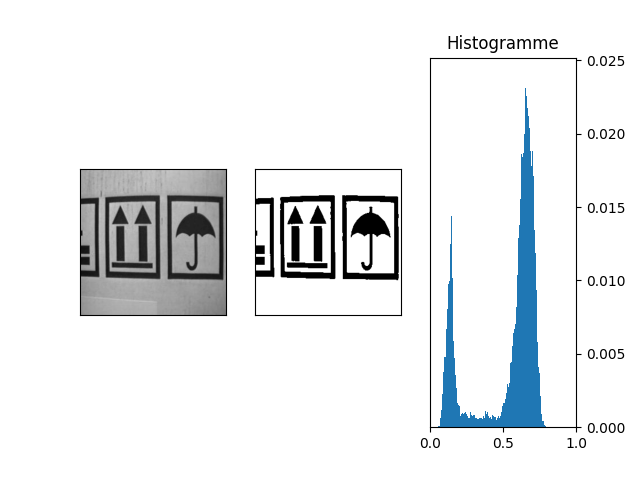

In [5]:
plt.close('all')
ima=lireImage('motifs.jpg')

# calcul de l'histogramme
nbbins=256
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=(0,1))
freq = freq/np.prod(ima.shape)

## EXERCICE: 
## programmer la méthode des k-means (k=2) pour trouver automatiquement le seuil
def TwoMeans1(i):
    """ Méthode des k-means avec k=2
        :param: i: l'image à seuiller
        :return: s: le seuil trouvé
    """
    # initialisation des centres: 0.25 et 0.75 (seuil=0.5)
    c_0,c_1=0.25,0.75
    s=0.5*(c_0+c_1)
    s_prev=s+1
    while not np.isclose(s,s_prev): # à effectuer tant que le seuil change
        s_prev = s # sauvegarde de l'ancien seuil
        c_0 = np.mean(i[i<s]) # calcul du nouveau centre pour la classe 0
        c_1 = np.mean(i[i>=s]) # calcul du nouveau centre pout la classe 1
        s=0.5*(c_0+c_1) # mise à jour du seuil
    
    # on renvoie le seuil final trouvé
    return s

def TwoMeans2(f,e):
    """ Méthode des k-means avec k=2
        :param: f: tableau des fréquences (renvoyé par np.histogram)
        :param: e: limites des classes dans l'histogramme (paramètre edges renvoyé par np.histogram)
        :return: s: le seuil trouvé
    """
    # calcul des centres de baquets. Sera utile pour le calcul d'intégrales
    x=0.5*(e[1:]+e[:-1])
    
    # précalcul des produits
    P = f
    Q = P*x
    
    # initialisation des centres: 0.25 et 0.75 (seuil=0.5)
    c_0,c_1=0.25,0.75
    s=0.5*(c_0+c_1)
    s_prev=s+1
    while not np.isclose(s,s_prev): # à effectuer tant que le seuil change
        s_prev = s # sauvegarde de l'ancien seuil
        k=np.where(e<s)[0][-1] # dernier indice de baquet à considérer
        n_0 = np.sum(Q[:k]) # calcul du nouveau numérateur pour la classe 0
        d_0 = np.sum(P[:k]) # calcul du nouveau dénominateur pour la classe 0
        n_1 = np.sum(Q[k+1:]) # calcul du nouveau numérateur pour la classe 1
        d_1 = np.sum(P[k+1:]) # calcul du nouveau dénominateur pour la classe 1
        # à noter que nous utiliserons un code plus efficace pour l'exercice suivant, en exploitant des
        # sommes cumulées pour les tableaux P et Q. Je laisse cependant ce code pour bien voir la progression
        # vers la solution proposée dans l'exercice suivant.
        
        # prise en compte du baquet limite
        l=(s-e[k])/(e[k+1]-e[k])
        n_0 += Q[k]*l
        d_0 += P[k]*l
        n_1 += Q[k]*(1-l)
        d_1 += P[k]*(1-l)
        
        # calcul des centres
        c_0 = 0 if np.isclose(d_0,0) else n_0/d_0
        c_1 = 1 if np.isclose(d_1,0) else n_1/d_1
        
        s=0.5*(c_0+c_1) # mise à jour du seuil
    
    # on renvoie le seuil final trouvé
    return s

seuil=TwoMeans1(ima)
print(f'seuil1={seuil}')
seuil=TwoMeans2(freq,edges)
print(f'seuil2={seuil}')
## FIN EXERCICE

#seuil=0.7
sima=ima.copy()
sima[ima<=seuil]=0
sima[ima>seuil]=1

# affichage: on ajoute un axe pour l'image seuillée
fig1, (iax, sax, hax) = plt.subplots(1,3)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

sax.get_xaxis().set_visible(False)
sax.get_yaxis().set_visible(False)
sdisp=sax.imshow(sima,vmin=0,vmax=1)

hax.set_title('Histogramme')
hax.yaxis.set_label_position("right")
hax.yaxis.tick_right()
hax.set_xlim([0,1])
hb=hax.bar(edges[:-1], freq, width=np.diff(edges),align="edge")

## Huitième exercice: la méthode de seuillage d'Otsu (avancé)

Otsu a proposé en 1979 (voir l'[article fourni dans l'archive](OTSU_paper.pdf)) une autre méthode de détermination automatique d'un seuil. L'idée repose sur le calcul d'un critère qui est d'autant plus petit que les deux classes sont bien séparées.

Plusieurs critères sont proposés et il est montré qu'ils sont équivalents. Je vous propose donc ici celui qui me semble le plus simple à comprendre : la variance intra-classes. Le seuil définit deux classes de pixels : ceux qui seront mis à 0 et ceux qui seront mis à 1. Pour un seuil donné, on peut donc calculer la variance sur la classe 0 et la variance sur la classe 1. Le seuil optimal sera celui qui proposera le meilleur compromis pour que ces variances soient les plus petites possibles.

Le critère qui calcule ce compromis fait la somme des variances, pondérées par leur probabilité de classe. Si $\omega_0$ est la probabilité d'appartenir à la classe 0 et $\sigma^2_0$ la variance sur cette classe, et $\omega_1$ est la probabilité d'appartenir à la classe 1, ayant $\sigma^2_1$ pour variance, le critère calculé est: $\sigma^2_w = \omega_0 \sigma^2_0 + \omega_1 \sigma^2_1$.

Le seuil recherché est celui qui minimise ce critère.

Question: implémenter la méthode d'Ostu. Pour cela, on pourra calculer le critère pour tous les seuils possibles et choisir le seuil qui correspond au critère minimal. A nouveau, une première version pourra faire les calculs à partir des pixels de l'image, mais devra utiliser l'histogramme, puis une deuxième version exploitera à profit uniquement l'histogramme de leurs valeurs (et les bords).

## Correction
Comme pour l'exercice précédent, on propose deux versions, la première (fonction <tt>Otsu1</tt>) 
recalculant les statistiques (ici variances) après sélection des pixels dans l'image; et la deuxième (fonction 
<tt>Otsu2</tt>) calculant ces mêmes statistiques à partir de l'histogramme.

Comme pour les k-means, on va établir les formules pour la classe 0, la démarche étant la même pour la classe 1.

La variance qu'on cherche à calculer est donnée par:

$\sigma_0^2 = \dfrac{\int_0^s (x-c_0)^2p(x) dx}{\int_0^s p(x) dx}$

où $c_0$ est la moyenne, suivant la même formule que les k-means:

$c_0 = \dfrac{\int_0^s xp(x) dx}{\int_0^s p(x) dx}$. 

De manière classique, on peut simplifier cette formule par:

$\sigma_0^2 = \dfrac{\int_0^s x^2p(x) dx}{\int_0^s p(x) dx} - c_0^2$

Par ailleurs, le poids à appliquer selon la formule d'Otsu est donné par:

$w_0 = \int_0^s p(x) dx$

On en déduit donc que 
$w_0 \sigma_0^2 = \int_0^s x^2p(x) dx - \dfrac{\left(\int_0^s xp(x) dx\right)^2}{\int_0^s p(x) dx}$

On a donc trois termes intégraux à calculer, sachant que deux d'entre eux ont été abordés dans la méthode des k-means. Le terme supplémentaire est ici calculé via $R_i = f_i x_i^2 = Q_i x_i$. À noter que nous n'avons pas à séparer un baquet entre les deux classes car la méthode ne va considérer que les bords de baquets comme seuils potentiels : les intégrales porteront donc sur des baquets entiers.


seuil=0.40625, critère=0.003966110849530833
seuil=0.40625, critère=0.00393518612656773


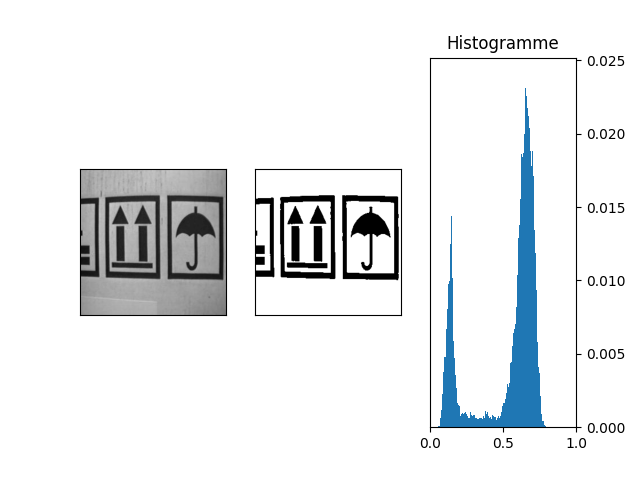

In [6]:
plt.close('all')
ima=lireImage('motifs.jpg')

# calcul de l'histogramme
nbbins=256
freq,edges=np.histogram(ima.ravel(),bins=nbbins,range=(0,1))
freq = freq/np.prod(ima.shape)

## EXERCICE: 
## programmer la méthode d'Otsu pour trouver automatiquement le seuil
def Otsu1(i):
    """ Méthode d'Otsu, sans exploitation de l'histogramme
        :param: i: image à traiter
        :return: s_opt,sigmaw2_opt: le seuil trouvé et la variance intra-classe correspondante (minimale)
    """
    # liste des seuils possibles
    e=np.linspace(0,1,257) # bords des classes
    t=e[1:] # seuils possibles: bords droits des classes
    
    # initialisation: on considère le seuil le plus haut (t[-1]): il n'y aucun valeur strictement au-dessus ce seuil
    # donc w0=1 et sigma0_2=variance sur l'image et w1=0 et sigma1=0. Tous les pixels sont dans la classe 0.
    sigmaw2_opt=np.var(i) # variance sur l'image
    s_opt=t[-1]
    
    # taille de l'image (pour le calcul des fréquences)
    npix = np.prod(i.shape)
    
    # passe en revue tous les seuils possibles. On ne traite pas le cas s=t[-1] déjà traité
    for s in t[:-1]: # s est le seuil courant.
        # calculs pour la classe 0 (strictement sous le seuil)
        w0=i[i<s].shape[0]/npix # calcul de w0 : p(I<s) = somme des fréquences jusqu'à l'indice courant (exclus)
        sigma0_2=0 if i.min() >= s else np.var(i[i<s]) # variance sur les pixels de l'image stritement sous le seuil 
                                                       # Note: le test sur le minimum est pour éviter de calculer une variance sur une liste vide
            
        # idem pour la classe 1 (égale ou au-dessus du seuil)
        w1=i[i>=s].shape[0]/npix
        sigma1_2=0 if i.max() < s else np.var(i[i>=s]) # cf Note ci-dessus pour le test
        
        # calcul du critère
        sigmaw2=w0*sigma0_2 + w1*sigma1_2
        
        # mise à jour de l'optimum si pertinent
        if sigmaw2 < sigmaw2_opt:
            sigmaw2_opt=sigmaw2
            s_opt=s
    
    # on renvoie le seuil optimal ainsi que la valeur du critère
    return s_opt,sigmaw2_opt


def Otsu2(f,e):
    """ Méthode d'Otsu, avec exploitation de l'histogramme
        :param: f: tableau des fréquences (renvoyé par np.histogram)
        :param: e: limites des classes dans l'histogramme (paramètre edges renvoyé par np.histogram)
        :return: s_opt,sigmaw2_opt: le seuil trouvé et la variance intra-classe correspondante (minimale)
    """      
    # de manière similaire à TwoMeans ci-dessus, on va précalculer les tableaux sur lesquels on fera des 
    # sommes partielles
    # calcul des centres de baquets. Sera utile pour le calcul d'intégrales
    x=0.5*(e[1:]+e[:-1])
    
    # précalcul des produits
    P = f # on peut remarquer que P[0] correspond à f[0], donc à un seuil fixé à e[1], bord droit du premier baquet
    Q = P*x 
    R = Q*x

    # comme on passe tous les seuils en revue, et qu'à chaque fois on fait la somme des k premiers éléments, on 
    # on utilise des tableaux cumulés pour la classe 0
    p_0=np.cumsum(P)
    q_0=np.cumsum(Q)
    r_0=np.cumsum(R)
    
    # on en déduit le complémentaire pour la classe 1
    p_1=p_0[-1] - p_0
    q_1=q_0[-1] - q_0
    r_1=r_0[-1] - r_0
    
    # on peut alors calculer les variances pondérées. On prend garde à gérer le cas où p_0 ou p_1 est nul
    sigma0w2 = np.zeros_like(r_0)
    i=np.logical_not(np.isclose(p_0,0))
    sigma0w2[i]=r_0[i]-q_0[i]**2/p_0[i]
    
    sigma1w2 = np.zeros_like(r_1)
    i=np.logical_not(np.isclose(p_1,0))
    sigma1w2[i]=r_1[i]-q_1[i]**2/p_1[i]
    
    # calcul du critère pour chaque seuil possible
    sigmaw2=sigma0w2+sigma1w2

    k=np.argmin(sigmaw2)
    return e[k+1],sigmaw2[k] # rappel : le seuil est le bord droit du baquet
    

seuil,copt=Otsu1(ima)
print(f'seuil={seuil}, critère={copt}')
seuil,copt=Otsu2(freq,edges)
print(f'seuil={seuil}, critère={copt}')
## FIN EXERCICE

#### RETIRE seuil=0.7
sima=ima.copy()
sima[ima<=seuil]=0
sima[ima>seuil]=1

# affichage: on ajoute un axe pour l'image seuillée
fig1, (iax, sax, hax) = plt.subplots(1,3)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
idisp=iax.imshow(ima,vmin=0,vmax=1)

sax.get_xaxis().set_visible(False)
sax.get_yaxis().set_visible(False)
sdisp=sax.imshow(sima,vmin=0,vmax=1)

hax.set_title('Histogramme')
hax.yaxis.set_label_position("right")
hax.yaxis.tick_right()
hax.set_xlim([0,1])
hb=hax.bar(edges[:-1], freq, width=np.diff(edges),align="edge")